In [1]:
import numpy as np
from qiskit import (
    QuantumCircuit,
    ClassicalRegister,
    QuantumRegister,
    execute,
    Aer,
    )
from qiskit.tools.visualization import plot_histogram
from itertools import product
from tqdm import tqdm

# Definition of th sign flip

$$\operatorname{SF}_{N,j} = O_j (C^NZ) O_j$$

$$O_j = \otimes_{l=0}^{N-1} (\operatorname{NOT}_l)^{1-j_l}$$

Choose $N$ and $j$. $j$ represents the elements of the computational basis.

In [2]:
def num2bin(num, n):
    return np.array([int(i) for i in np.binary_repr(num, n)[::-1]])

def O(q, j):
    O_circ = QuantumCircuit(q, name=f"O_{''.join([str(i) for i in j])}")

    for (i, v) in enumerate(j):
        if v == 0:
            O_circ.x(q[i])
    return  O_circ

def sf(q, j):
    N = q.size
    SF = QuantumCircuit(q, name=f"SF_{q.size}_{''.join([str(i) for i in j])}")
    SF.append(O(q, j), q)
    SF.barrier(q)
    SF.mcrz(np.pi, q[:N-1], q[N-1])
    SF.barrier(q)
    SF.append(O(q, j), q)    
    return SF

In [3]:
def U_i(q, input_vector):
    u_i = QuantumCircuit(q, name=f"U^i_{''.join([str(i) for i in input_vector])}")
    N = q.size
    u_i.h(q)
    for (i, v) in enumerate(input_vector):
        if v:
            bin_num = num2bin(i, N)
            u_i.append(sf(q, bin_num), q)
    return u_i

In [4]:
def U_w(q, weight_vector):
    u_w = QuantumCircuit(q, name=f"U^w_{''.join([str(i) for i in weight_vector])}")
    N = q.size
    for (i, v) in enumerate(weight_vector):
        if v:
            bin_num = num2bin(i, N)
            u_w.append(sf(q, bin_num), q)
    u_w.h(q)
    u_w.x(q)
    return u_w

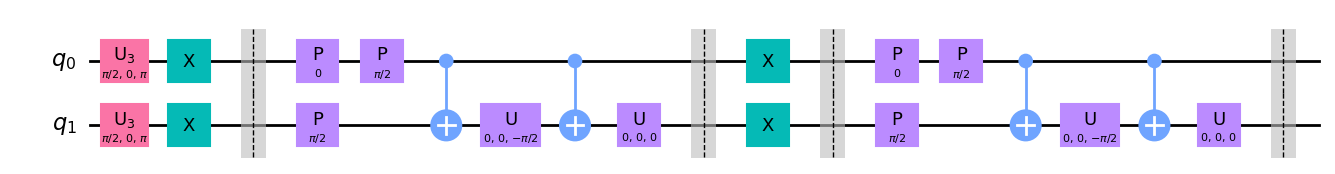

In [5]:
N = 2
q = QuantumRegister(N, 'q')
input_vector = [1, 0, 0, 1]
circ = QuantumCircuit(q)
circ.append(U_i(q, input_vector), q)
circ.decompose(reps=3).draw(output='mpl')

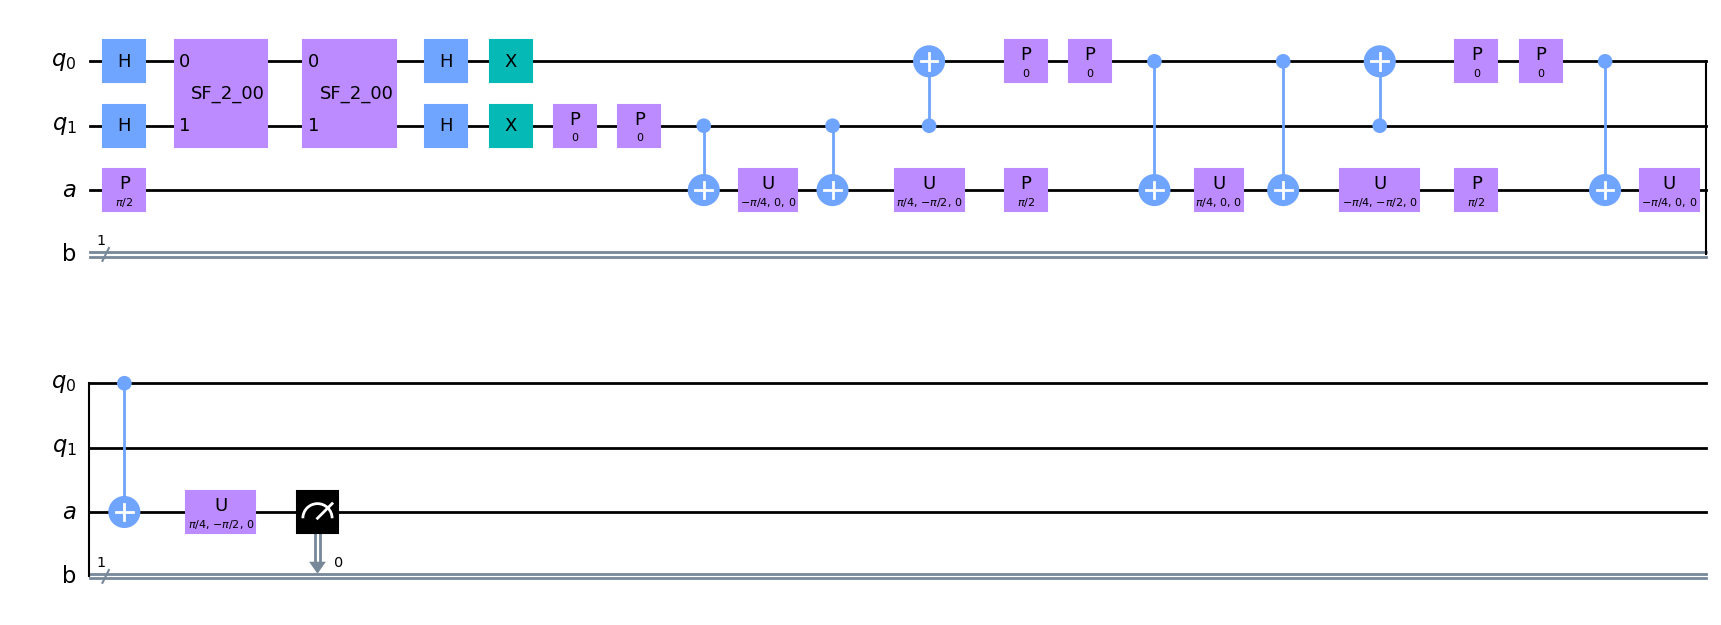

In [6]:
N = 2
q = QuantumRegister(N, 'q')
a = QuantumRegister(1, 'a')
b = ClassicalRegister(1, 'b')
circ = QuantumCircuit(q, a, b)
circ.append(U_i(q, num2bin(1, N)), q)
circ.append(U_w(q, num2bin(1, N)), q)
circ.mcrx(np.pi, q, a[0])
circ.measure(a, b)
circ.decompose(reps=1).draw(output='mpl')


Total counts are: {'1': 1024}


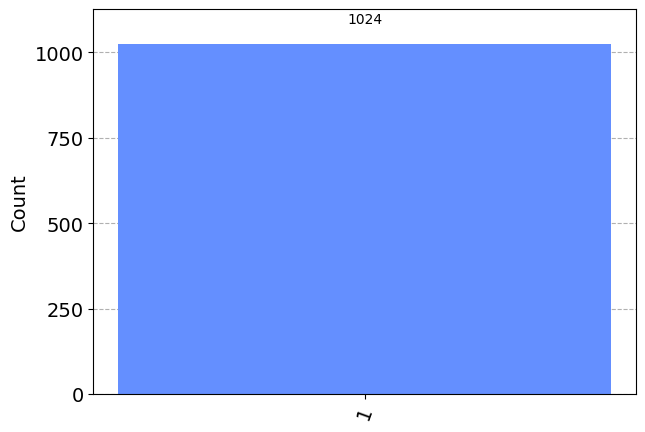

In [7]:
simulator = Aer.get_backend('qasm_simulator')
job = execute(circ, simulator, shots=1024)
result = job.result()
counts = result.get_counts(circ)
print("\nTotal counts are:",counts)
plot_histogram(counts)

# Input vs weights matrix

Below we compare all the input vectors against all the weight vectors, for a specified $N$. We're computing a square matrix with a side of $2^{2^N}$ elements.

Start with $N=2$ to see results within your lifetime.

The results are saved in **outcomes**, and can be viewed in an image in the cell below.

In [8]:
N = 2
shots = 1024
outcomes = np.zeros((2**(2**N),2**(2**N)))
for (i, w) in tqdm(product(range(2**(2**N)), repeat=2)):
    q = QuantumRegister(N, 'q')
    a = QuantumRegister(1, 'a')
    b = ClassicalRegister(1, 'b')
    circ = QuantumCircuit(q, a, b)
    circ.append(U_i(q, num2bin(i, 2*N)), q)
    circ.append(U_w(q, num2bin(w, 2*N)), q)
    circ.mcrx(np.pi, q, a[0])
    circ.measure(a, b)

    simulator = Aer.get_backend('qasm_simulator')
    job = execute(circ, simulator, shots=shots)
    result = job.result()
    counts = result.get_counts(circ)
    if len(counts) == 1:
        outcomes[i][w] = int([*counts][0])
    else:
        outcomes[i][w] = counts['1'] / shots

256it [00:06, 40.27it/s]


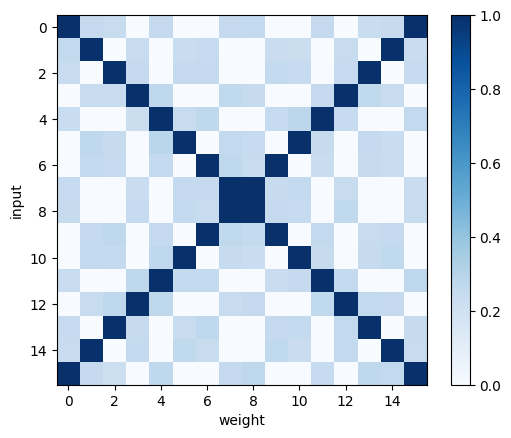

In [9]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
ax.set_xlabel("weight")
ax.set_ylabel("input")

out_plot = ax.imshow(outcomes, cmap='Blues', interpolation='none')
fig.colorbar(out_plot, ax=ax)

# Quantum device

In [10]:
import os
from qiskit import IBMQ, transpile

hub = 'ibm-q-psnc'
group = 'internal'
project = 'reservations'
backend = 'ibmq_kolkata'

In [11]:
provider = IBMQ.enable_account(
                "df9384b1ea9f6d0f2325a0035bbcb3e73e7d31c17c348579587ef1ad08693245784707c880651b13d3c85165b415af739e80f2c342f0b07d245247caca98790b",
                hub=hub,
                group=group,
                project=project,
            )


/tmp/ipykernel_327828/127954277.py:1: DeprecationWarning: The package qiskit.providers.ibmq is being deprecated. Please see https://ibm.biz/provider_migration_guide to get instructions on how to migrate to qiskit-ibm-provider (https://github.com/Qiskit/qiskit-ibm-provider) and qiskit-ibm-runtime (https://github.com/Qiskit/qiskit-ibm-runtime).
  provider = IBMQ.enable_account(
/tmp/ipykernel_327828/127954277.py:1: DeprecationWarning: The qiskit.IBMQ entrypoint and the qiskit-ibmq-provider package (accessible from 'qiskit.providers.ibmq`) are deprecated and will be removed in a future release. Instead you should use the qiskit-ibm-provider package which is accessible from 'qiskit_ibm_provider'. You can install it with 'pip install qiskit_ibm_provider'. Just replace 'qiskit.IBMQ' with 'qiskit_ibm_provider.IBMProvider'
  provider = IBMQ.enable_account(


In [12]:
N = 2
q = QuantumRegister(N, 'q')
a = QuantumRegister(1, 'a')
b = ClassicalRegister(1, 'b')
circ = QuantumCircuit(q, a, b)
circ.append(U_i(q, num2bin(1, N)), q)
circ.append(U_w(q, num2bin(1, N)), q)
circ.mcrx(np.pi, q, a[0])
circ.measure(a, b)

backend = provider.get_backend(backend)
transpiled = transpile(circ, backend=backend)
job = backend.run(transpiled)
retrieved_job = backend.retrieve_job(job.job_id())

In [19]:
counts = retrieved_job.result().get_counts()

# Error mitigation

In [14]:
import mthree
mit2 = mthree.M3Mitigation(backend)


In [17]:
mit2.cals_from_system()

In [23]:
mit2.apply_correction(counts, [6])

{'0': 0.10219397225988128, '1': 0.8978060277401188}

In [25]:
counts['1']/4000

0.886